In [10]:
import pandas as pd
import pickle,os, copy
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys


import re

from sklearn.cluster import DBSCAN


from deep_generalizability.nets import Nets
from deep_generalizability.utils import *
from deep_generalizability.postprocessing.postprocessing import *
from deep_generalizability.postprocessing.stats_plotting import *
from deep_generalizability.save_load import *

from deep_generalizability.postprocessing.sharpness_measures import *
from deep_generalizability.postprocessing.stats_plotting import *

from deep_generalizability.data_getters import *

%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (13,9)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "CIFAR10"
exp = "Sep06_21-46-13_Daniels-MacBook-Pro-4.local"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp)

In [25]:
stats_df = get_end_stats(experiment_folder, step=-1)


In [26]:
stats_df.sort_values(by="Acc Test Max", ascending=False)

,Acc Gap Mean,Acc Test Max,Acc Test Mean,Acc Test Min,Acc Train Max,Acc Train Mean,Acc Train Min,Loss Test Max,Loss Test Mean,Loss Test Min,Loss Train Max,Loss Train Mean,Loss Train Min,Norm Max,Norm Mean,Norm Min,batch_train_size
1599421593.022805,-0.1070,0.5736,0.5736,0.5736,0.6806,0.6806,0.6806,1.22457,1.22457,1.22457,0.926932,0.926932,0.926932,14.469574,14.469574,14.469574,256
1599421591.40348,-0.0290,0.4732,0.4732,0.4732,0.5022,0.5022,0.5022,1.46552,1.46552,1.46552,1.367270,1.367270,1.367270,13.879993,13.879993,13.879993,32
1599421589.217978,-0.0058,0.4164,0.4164,0.4164,0.4222,0.4222,0.4222,1.59247,1.59247,1.59247,1.566297,1.566297,1.566297,13.275649,13.275649,13.275649,16


In [224]:
point_traces, meta = load_cached_data(experiment_folder, "point_traces", step=-1)

In [213]:
margin_filters = get_exp_margins(experiment_folder, softmax_outputs=False, step=-1, seed=0, device=None, num_datapoints=100, on_test_set=False, should_cache=False)


In [214]:
linear_loss_trace_filters = get_exp_linear_loss_trace(experiment_folder, step=-1, seed=0, device=None, num_datapoints=100, on_test_set=False, should_cache=False)


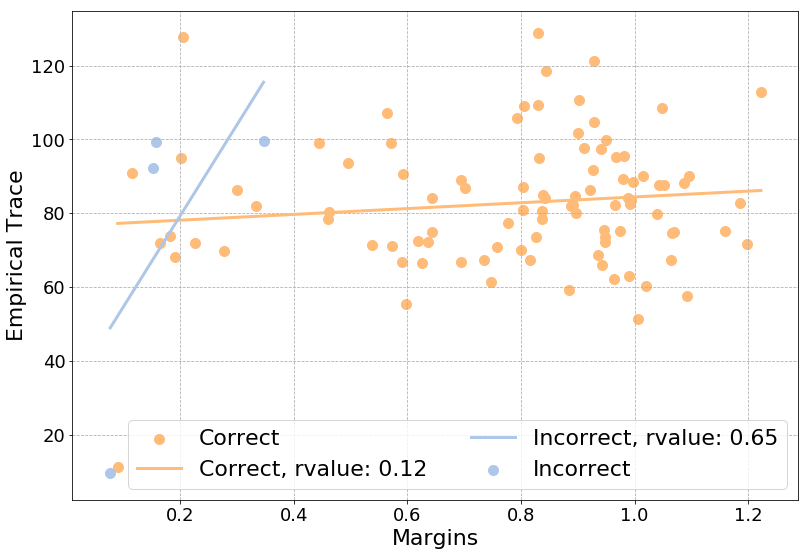

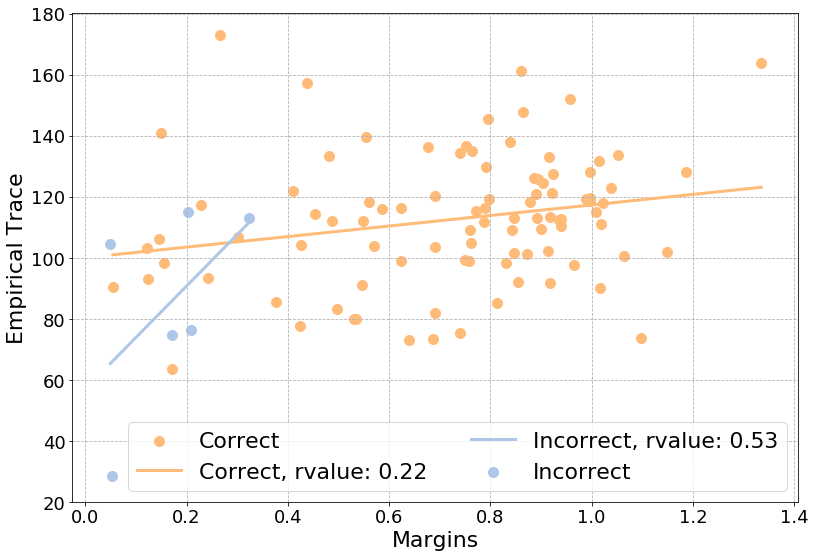

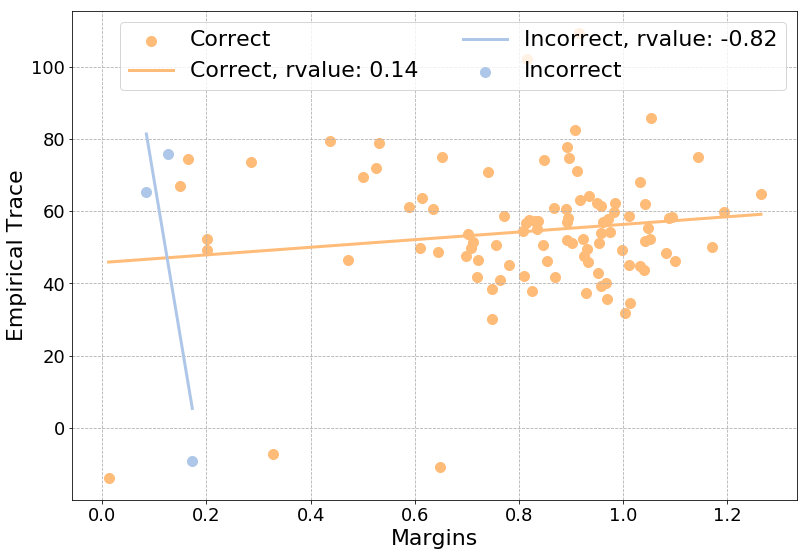

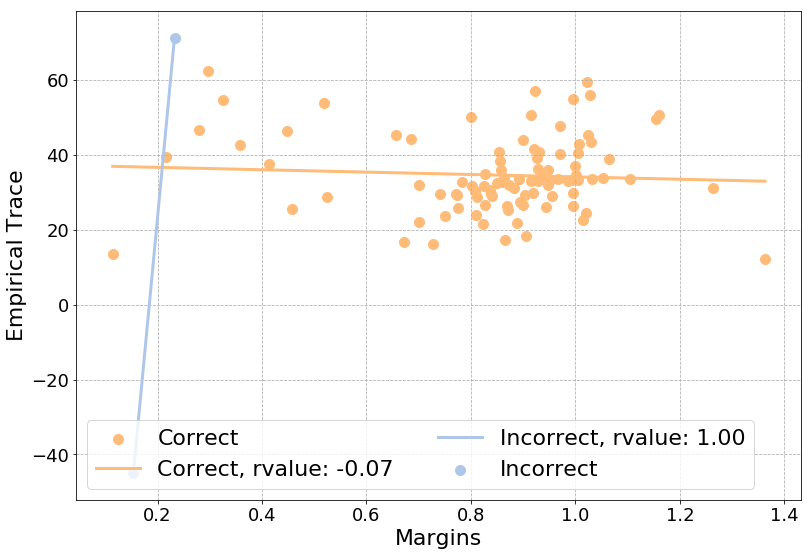

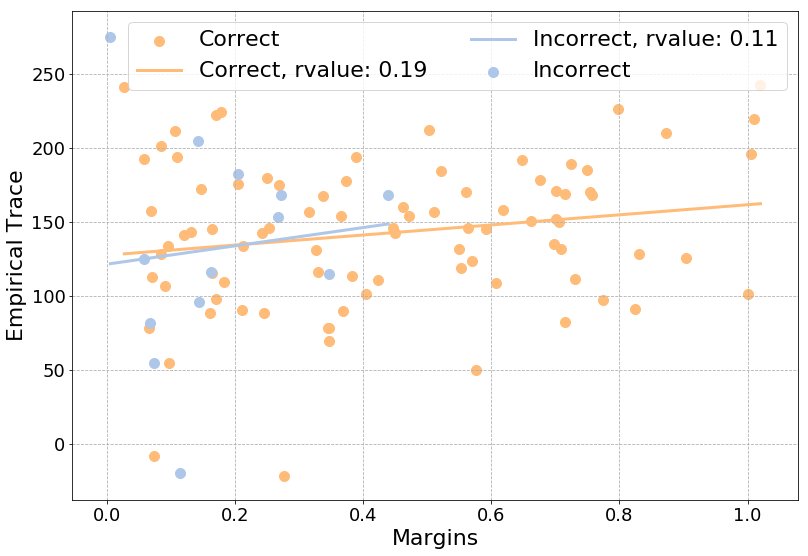

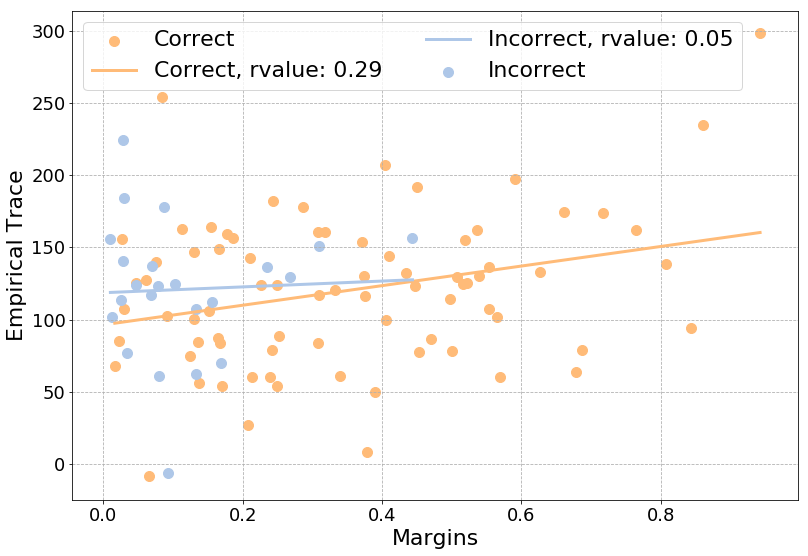

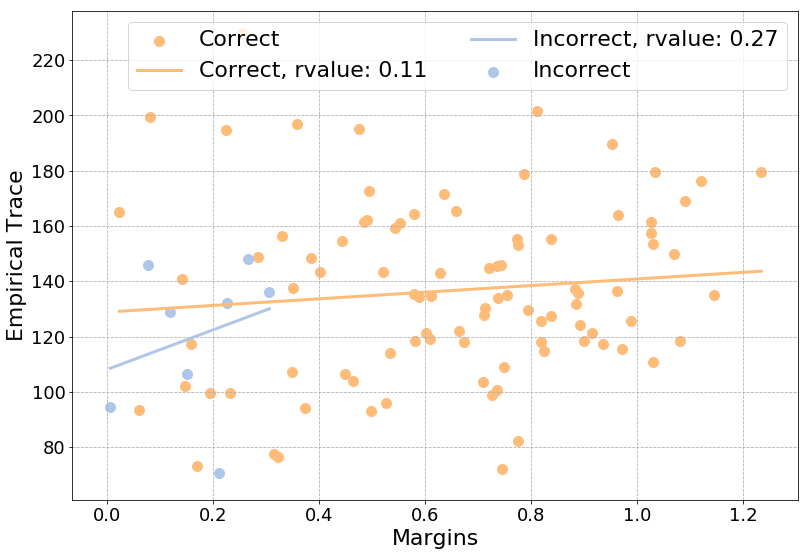

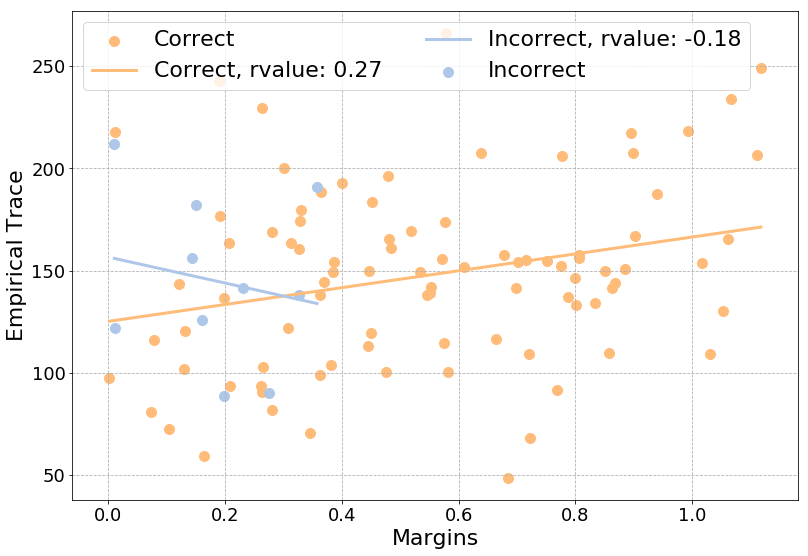

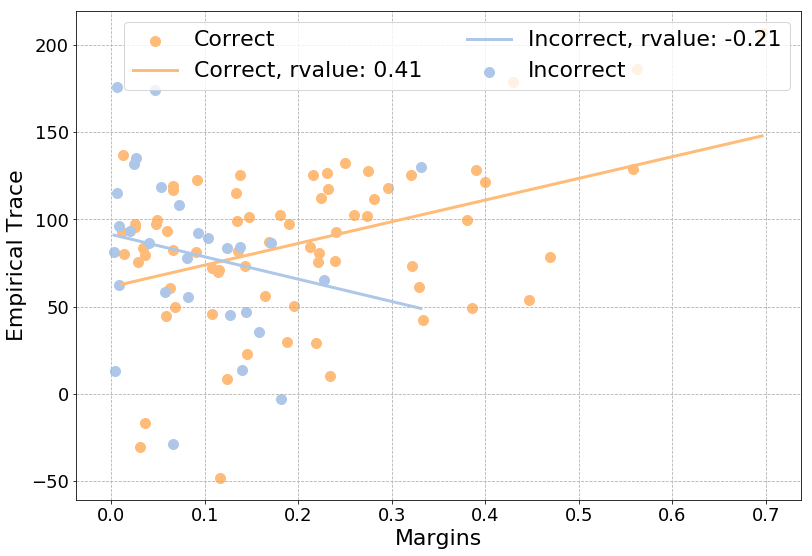

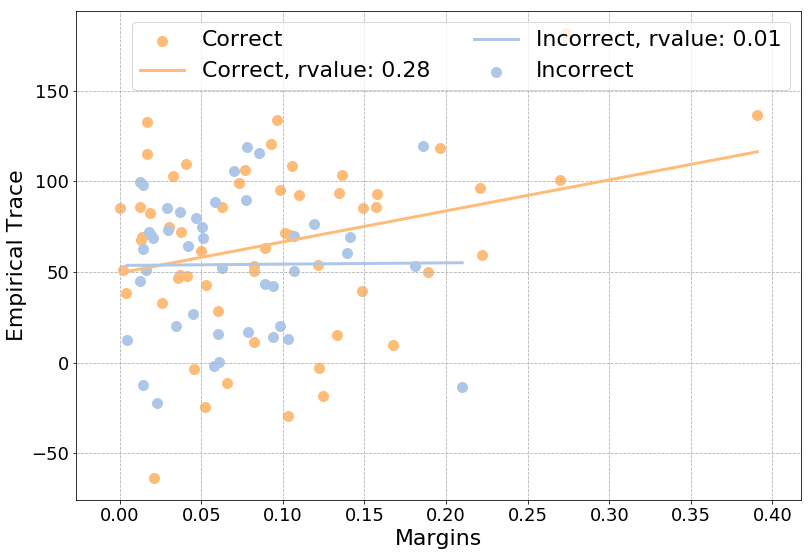

In [186]:

# Plot trace vs margins
X_axis_name = "Margins"
Y_axis_name = "Empirical Trace"


plot_name = "Correct_Incorrect"
X_axis_bounds = None
Y_axis_bounds = None

save_exp_path = experiment_folder

filter_seperate = ["learning_rate"]
filter_not_seperate = None

pre_filtered_exp_ids = None

use_correct_filter = True
draw_correlation = True

data_func = margin_trace_correct_incorrect_plot(margin_filters, point_traces, use_correct_filter=use_correct_filter, draw_correlation=draw_correlation)

hp_data_func_plot(experiment_folder, data_func, X_axis_name, Y_axis_name, 
                  plot_name, filter_seperate, filter_not_seperate,
                 save_exp_path, X_axis_bounds, Y_axis_bounds, 
                    pre_filtered_exp_ids)



In [225]:
all_steps = get_exp_steps(experiment_folder)
all_steps = np.array([list(v.keys()) for v in all_steps.values()]).reshape(-1)
all_steps = sorted(list(set(all_steps)))

In [226]:
# Plot trace vs margins
X_axis_name = "Margins"
Y_axis_name = "Empirical Trace"


plot_name = "Correct_Incorrect"
X_axis_bounds = None
Y_axis_bounds = None

save_exp_path = experiment_folder

filter_seperate = ["learning_rate"]
filter_not_seperate = None

pre_filtered_exp_ids = None

use_correct_filter = True
draw_correlation = True



0
{'1599166458.279648': {'0': (0.1016, 0.1068)}}


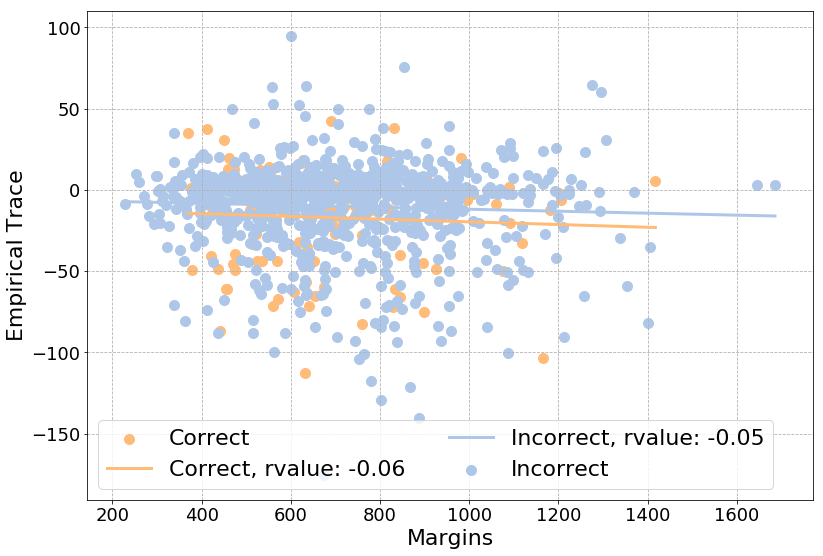

1
{'1599166458.279648': {'0': (0.1046, 0.108)}}


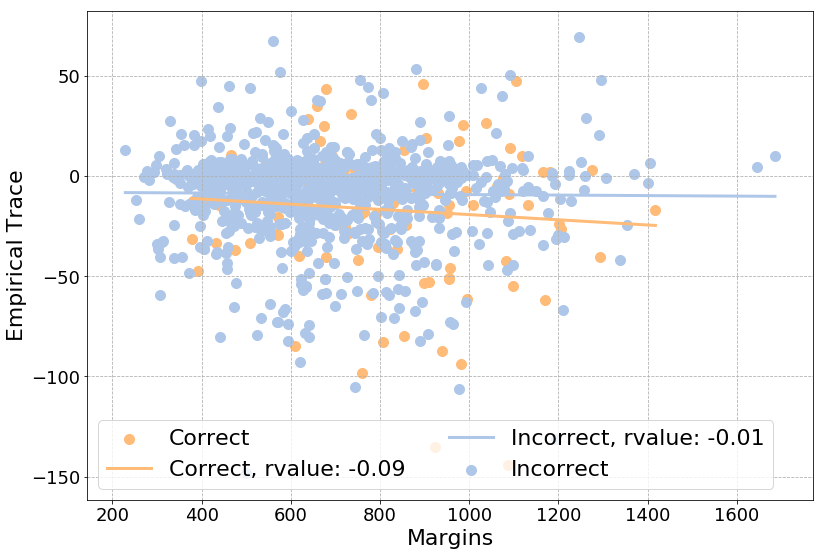

101
{'1599166458.279648': {'0': (0.225, 0.224)}}


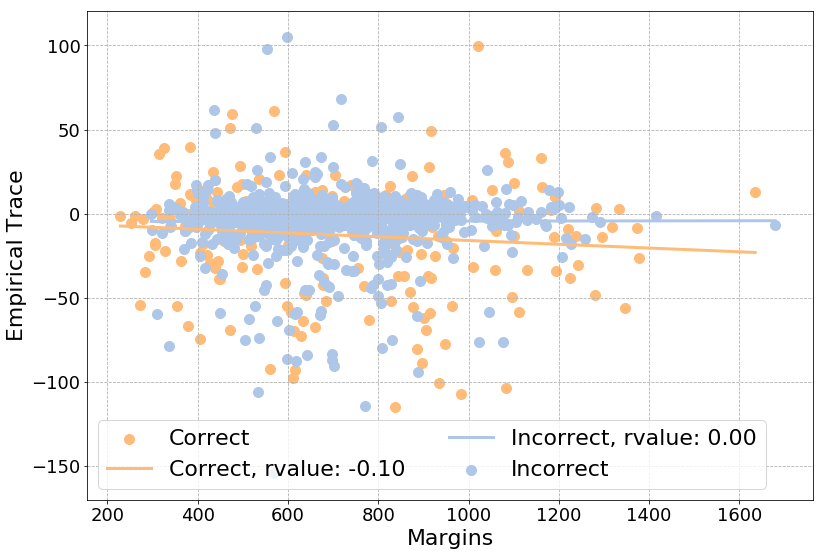

201
{'1599166458.279648': {'0': (0.4864, 0.4798)}}


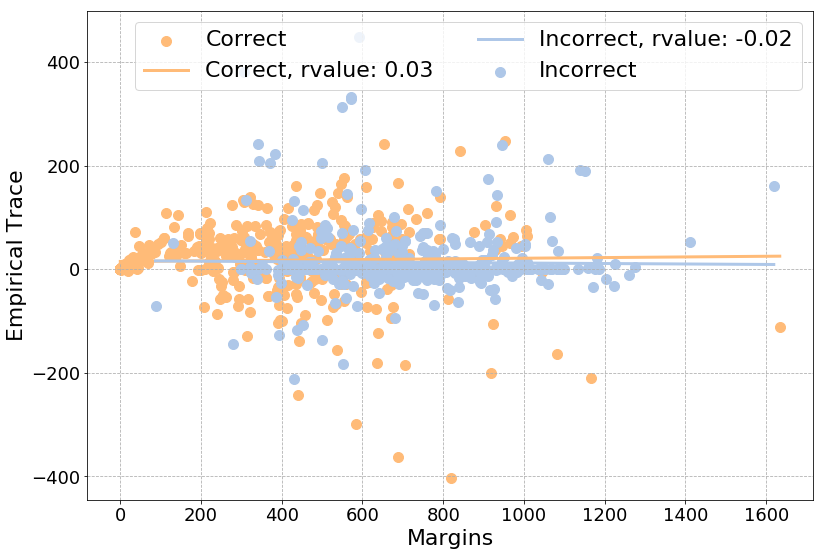

301
{'1599166458.279648': {'0': (0.5628, 0.5662)}}


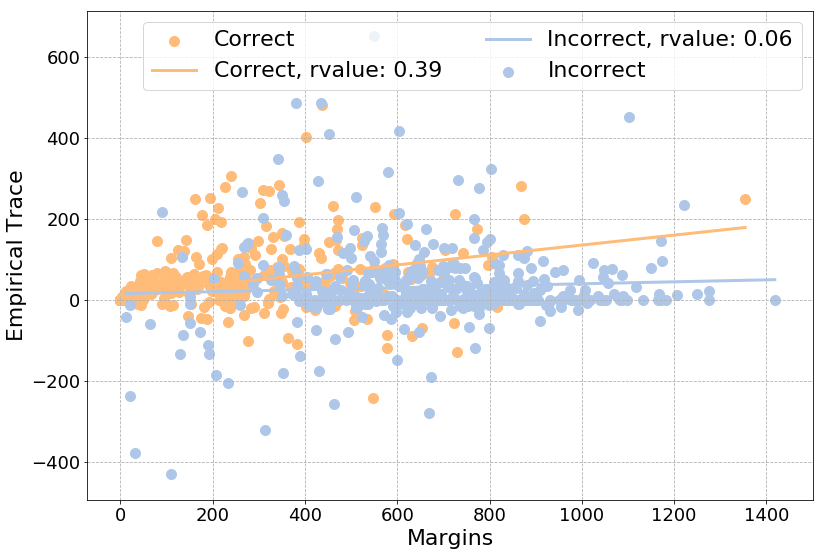

401
{'1599166458.279648': {'0': (0.562, 0.5648)}}


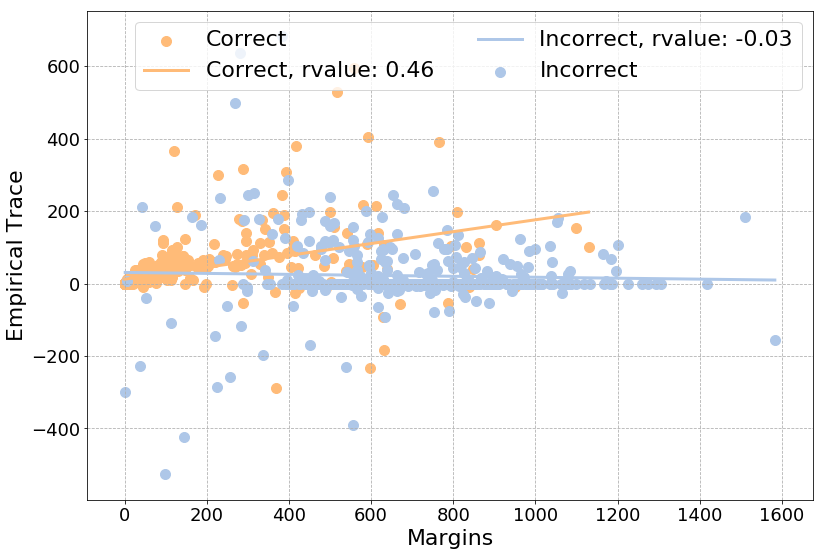

501
{'1599166458.279648': {'0': (0.52, 0.5296)}}


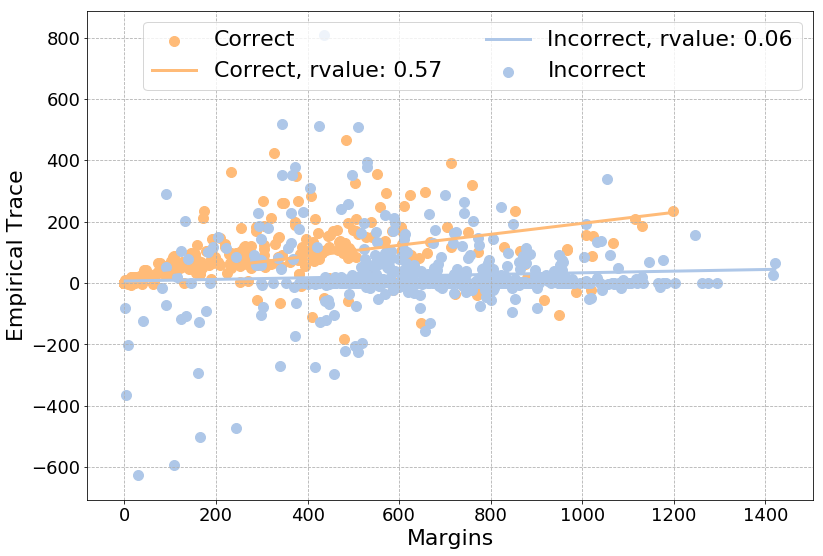

601
{'1599166458.279648': {'0': (0.7336, 0.735)}}


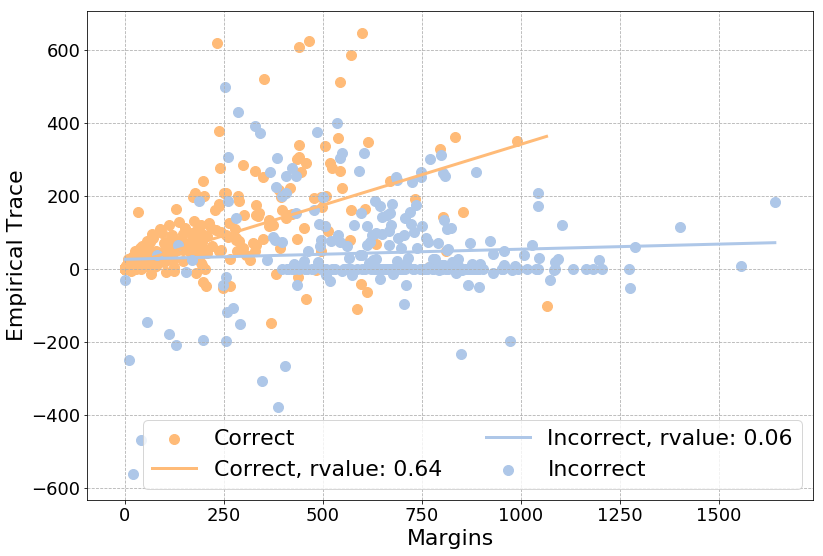

701
{'1599166458.279648': {'0': (0.7582, 0.7536)}}


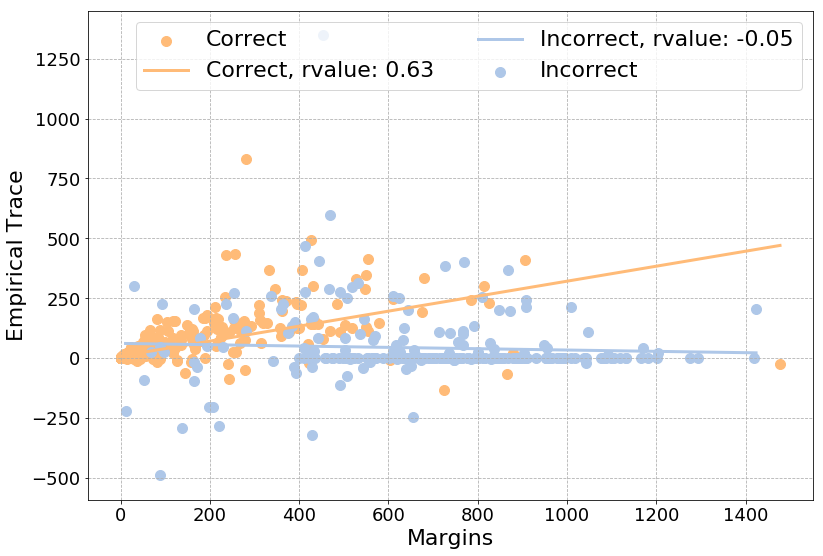

801
{'1599166458.279648': {'0': (0.7582, 0.7564)}}


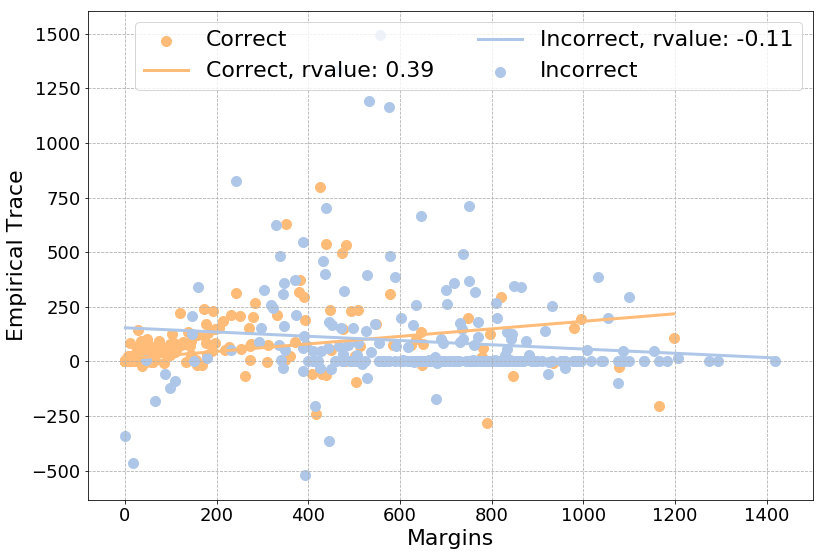

901
{'1599166458.279648': {'0': (0.8054, 0.8048)}}


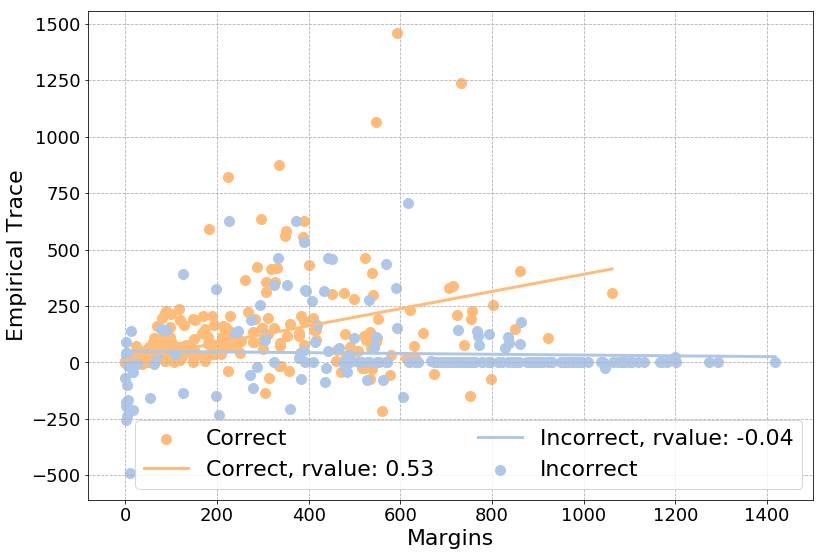

1001
{'1599166458.279648': {'0': (0.834, 0.823)}}


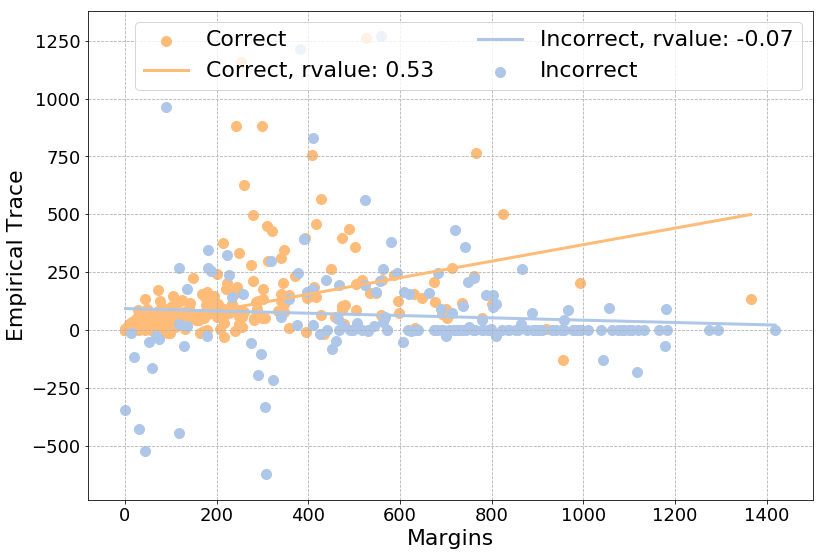

1101
{'1599166458.279648': {'0': (0.2132, 0.1996)}}


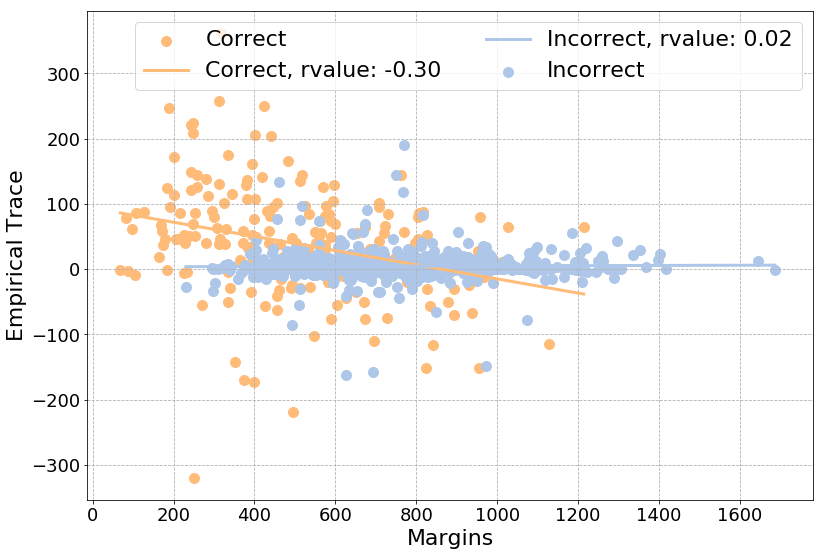

1201
{'1599166458.279648': {'0': (0.7314, 0.7338)}}


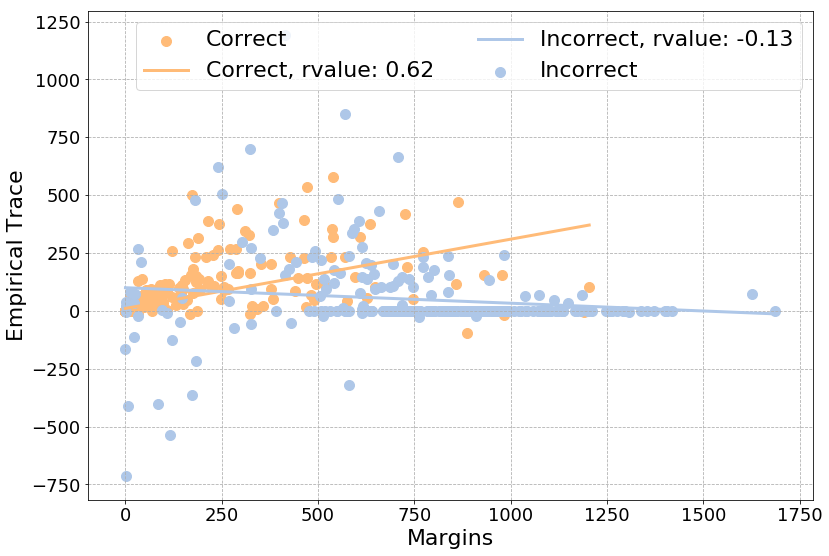

1301
{'1599166458.279648': {'0': (0.8366, 0.8304)}}


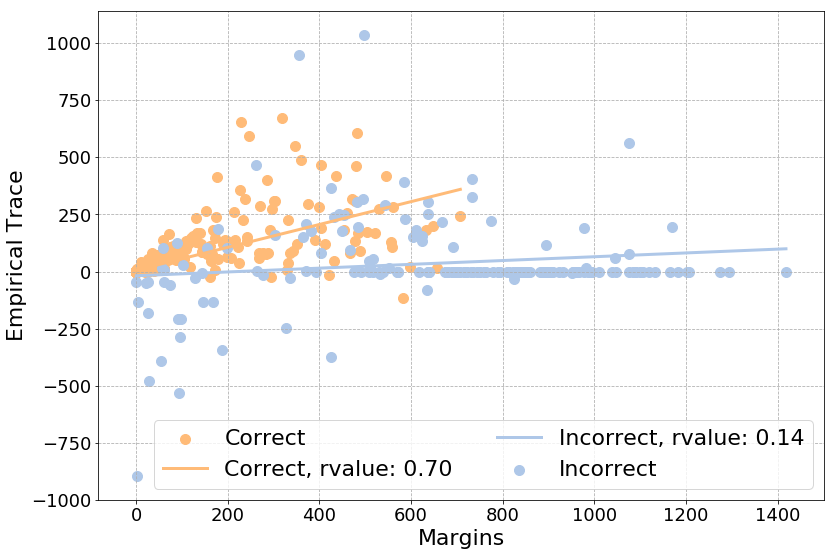

1401
{'1599166458.279648': {'0': (0.8026, 0.7948)}}


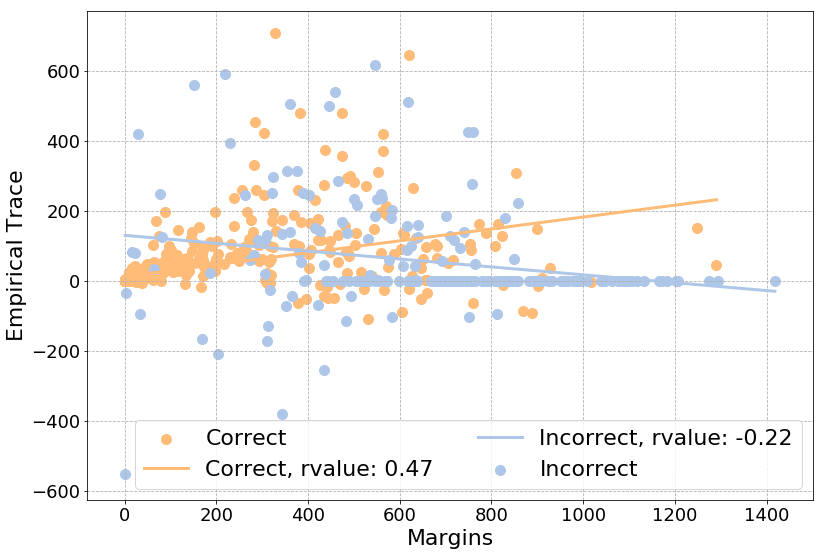

1501
{'1599166458.279648': {'0': (0.8254, 0.816)}}


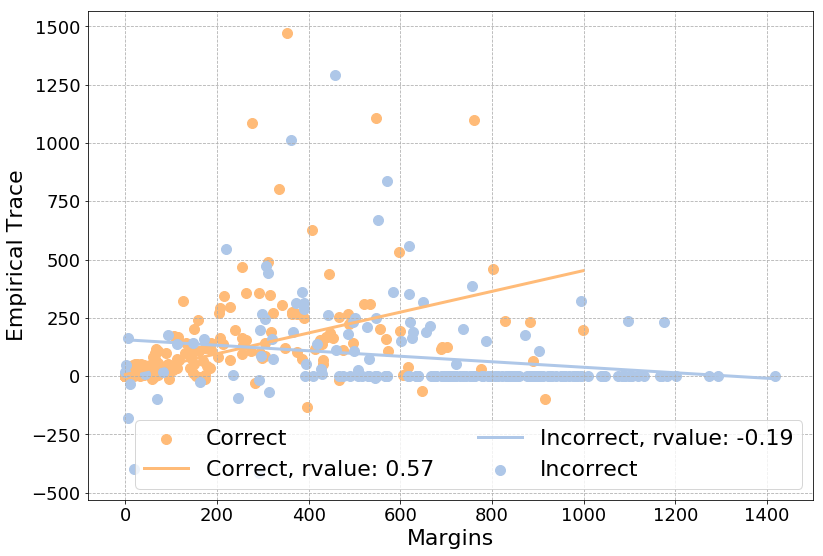

1601
{'1599166458.279648': {'0': (0.8432, 0.8344)}}


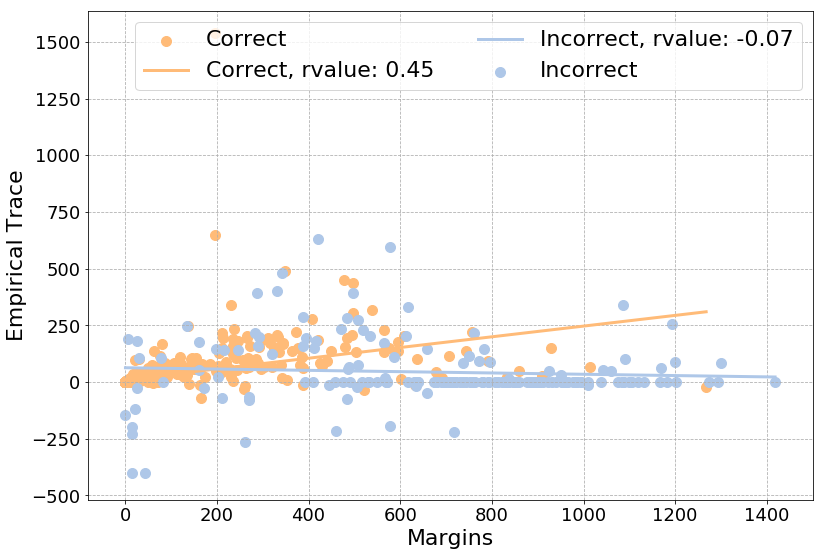

1701
{'1599166458.279648': {'0': (0.8466, 0.8436)}}


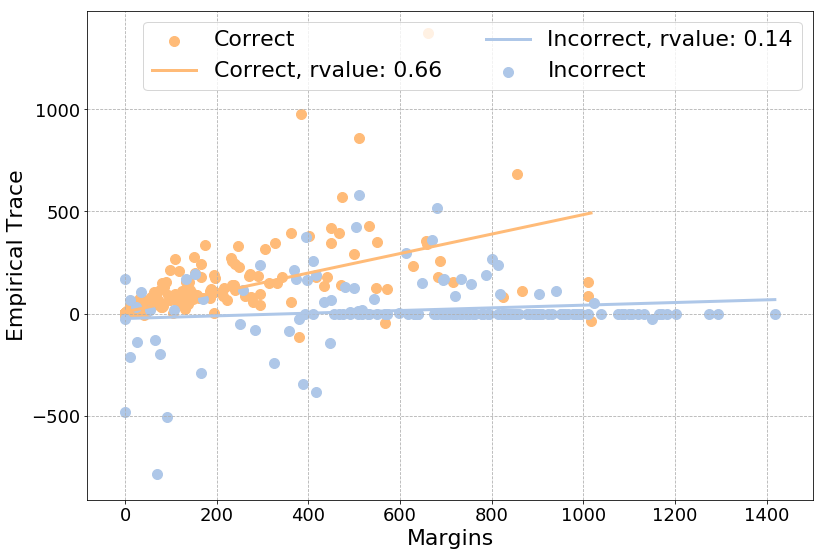

1801
{'1599166458.279648': {'0': (0.835, 0.833)}}


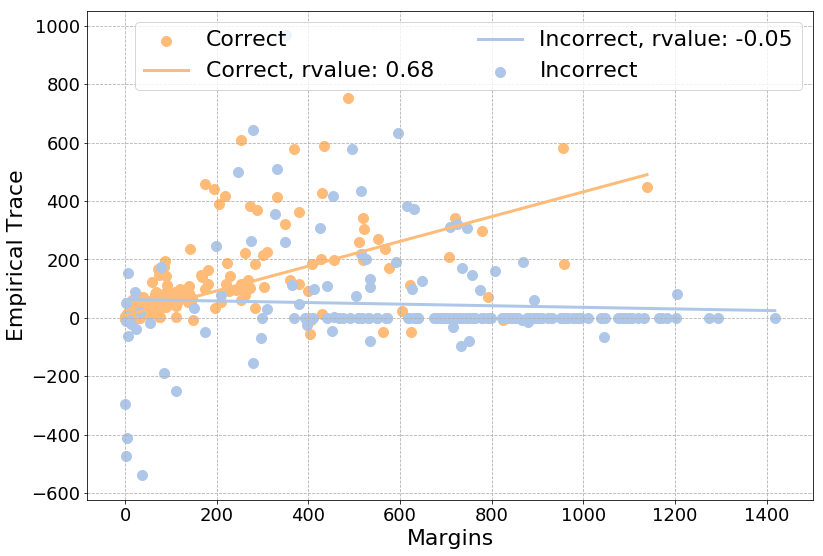

1901
{'1599166458.279648': {'0': (0.797, 0.7896)}}


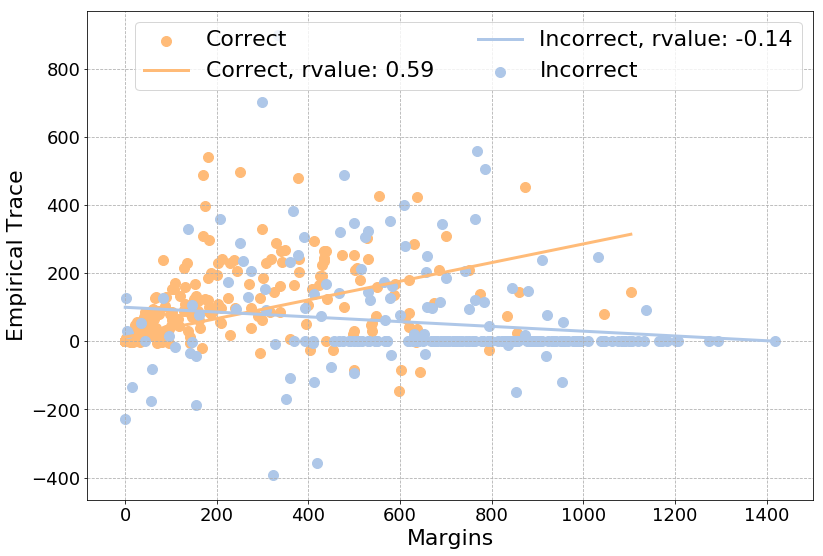

2001
{'1599166458.279648': {'0': (0.8538, 0.8424)}}


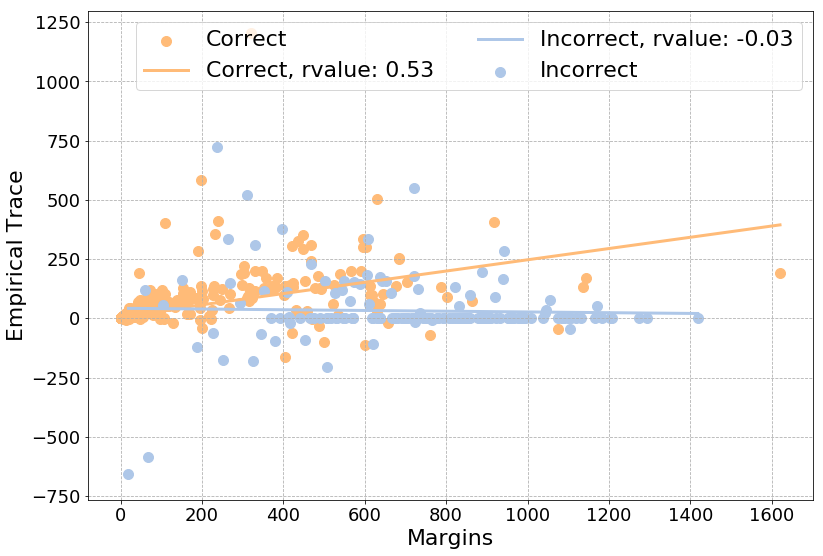

In [227]:
for step in all_steps:
    print(step)
    acc, _ = load_cached_data(experiment_folder, "acc", step=step)
    print(acc)
    
    curr_point_traces, meta = load_cached_data(experiment_folder, "point_traces", step=step)
    linear_loss_trace_filters = get_exp_linear_loss_trace(experiment_folder, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)

    data_func = margin_trace_correct_incorrect_plot(linear_loss_trace_filters, curr_point_traces, use_correct_filter=use_correct_filter, draw_correlation=draw_correlation)

    hp_data_func_plot(experiment_folder, data_func, X_axis_name, Y_axis_name, 
                      plot_name, filter_seperate, filter_not_seperate,
                 save_exp_path, X_axis_bounds, Y_axis_bounds, 
                    pre_filtered_exp_ids)

